In [1]:
#Toy example: this does not mean anything really, just write out some random returns series and find the maximum level (this was born as a unit test basically, for the logic of a private application).

In [2]:
#requires py3.7 scipy==1.1.0 (conda)
#requires pyDOE (pip)

In [3]:
from dnlcb import DynamicNegativeLowerConfidenceBound
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.optimization import RandomSearchAcquisitionOptimizer
from emukit.model_wrappers import GPyModelWrapper
from GPy.models import GPRegression
from GPy.kern.src.brownian import Brownian
from matplotlib import pyplot as plt
import numpy as np
from pandas import Series
import random

In [4]:
#time horizon
parameter_space = ParameterSpace([ContinuousParameter('days', 0, 251)])

In [5]:
#Sample some arithmetic brownian motion, e.g. returns.
def ABM(
    X0: float = 100,
    T: int = 252,
    n: int = 1,
    alpha: float = 0,
    sigma: float = 100
) -> Series:
    dt = n/T
    X = Series([X0])
    for i in np.arange(1, T):
        ei = np.random.normal(0, 1)
        X.loc[i] = X.loc[i-1] + alpha*dt + sigma*ei*(dt**0.5)
    return X.to_numpy()
data = ABM(sigma=100, alpha=200)
def f(x):
    i=np.round(x).astype(int)
    return -data[i]

In [6]:
def XY():
    x = np.array(np.array([random.uniform(0, 251)]))
    y = f(x)
    return (x, y)

X = np.zeros(5)
Y = np.zeros(5)
for i in range(5):
    x,y = XY()
    X[i] = x
    Y[i] = y

X_init = X[:, None]
Y_init = Y[:, None]

#Kernel choice: brownian. This kernel is hardly used in applications, the most common non-smooth kernel is a fractional Matérn I guess. Something very inconvenient with a brownian kernel is its not-differentiability, and the fact that it is strictly one-dimensional (at least in its classic definition): this forces you to marginalize on the dimensions, with an overhead linear in the number of dimensions of course.
#This said it is technically the best assumption if your underlying process does have a brownian nature, like in this example.
kernel = Brownian(variance=np.var(X_init))

#Negate Y_init results as we are solving the dual problem (see below)
#Train and wrap the model in Emukit
model_gpy = GPRegression(X_init,-Y_init,kernel=kernel) 
model_emukit = GPyModelWrapper(model_gpy)

#Attention: DNLCB does *not* have convergence guarantees for non-smooth kernel surfaces (see paper), like a brownian ones; this basically means we have no guarantee to find the optimum no matter the number of iterations. As this is a toy example on a conveniently discretized space it's all good, but with real applications be careful on the acquisition choice.
#The input space size must be the same as the parameter space range (see above); starting with a low delta.
dynamic_lcb = DynamicNegativeLowerConfidenceBound(model = model_emukit,input_space_size=252, delta=0.2)
#A brownian motion is nowhere differentiable so its gradient function https://gpy.readthedocs.io/en/deploy/tuto_creating_new_kernels.html#gradients-x-self-dl-dk-x-x2 is undefined; this also means we cannot use any gradient-based acquisition optimizer
acquisition_optimizer = RandomSearchAcquisitionOptimizer(parameter_space, 30)
bayesopt_loop_cust = BayesianOptimizationLoop(
    model = model_emukit,
    space = parameter_space,
    acquisition = dynamic_lcb,acquisition_optimizer=acquisition_optimizer,
    batch_size = 1
)

def f_opt(x):
    return -f(x)
bayesopt_loop_cust.run_loop(f_opt, 30)

Optimization restart 1/1, f = 29.279123124455648
Optimization restart 1/1, f = 34.93570676177013
Optimization restart 1/1, f = 39.928979844591495
Optimization restart 1/1, f = 45.211498792095654
Optimization restart 1/1, f = 49.95899419722093
Optimization restart 1/1, f = 54.67035697793573
Optimization restart 1/1, f = 59.08717104760607
Optimization restart 1/1, f = 63.53573969652588
Optimization restart 1/1, f = 67.90604284587715
Optimization restart 1/1, f = 72.2184584245642
Optimization restart 1/1, f = 78.60892891690877
Optimization restart 1/1, f = 82.79609560462131
Optimization restart 1/1, f = 86.97253786872187
Optimization restart 1/1, f = 91.18124885762572
Optimization restart 1/1, f = 95.29960384879091
Optimization restart 1/1, f = 99.21926591327387
Optimization restart 1/1, f = 103.90490992142892
Optimization restart 1/1, f = 108.19709214671423
Optimization restart 1/1, f = 112.21255762941593
Optimization restart 1/1, f = 116.40127260736683
Optimization restart 1/1, f = 120.

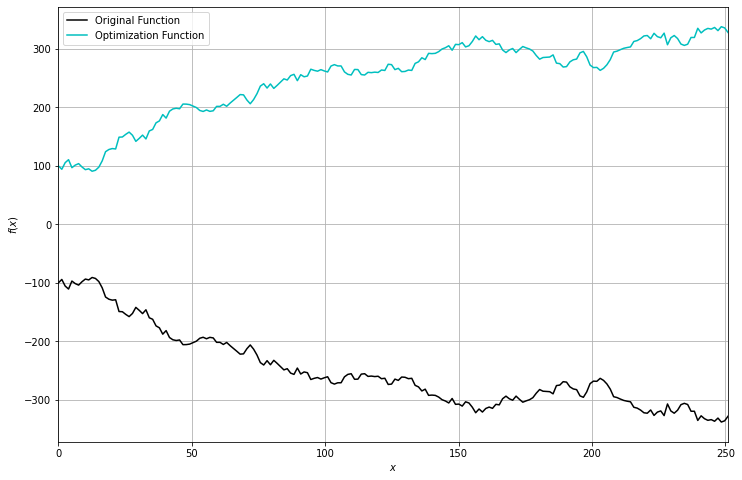

In [7]:
#The optimization engine can only minimize, apparently; so to maximize the original function we will minimize its inverse, by duality max(f)=min(-f).
smin=parameter_space.parameters[0].min
smax=parameter_space.parameters[0].max
x_plot = np.linspace(smin, smax , 200)[:, None]
y_plot = f(x_plot)
z_plot = f_opt(x_plot)
plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot, "k", label="Original Function")
plt.plot(x_plot, z_plot, "c", label="Optimization Function")
plt.legend(loc=2, prop={'size': 10})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(smin, smax)
plt.show()

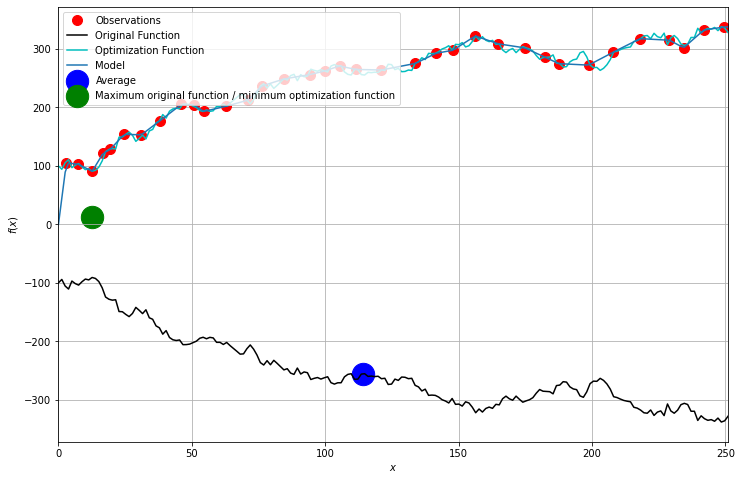

In [8]:
mu_plot, var_plot = bayesopt_loop_cust.model.predict(x_plot)
plt.figure(figsize=(12, 8))
plt.plot(bayesopt_loop_cust.loop_state.X, bayesopt_loop_cust.loop_state.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Original Function")
plt.plot(x_plot, z_plot, "c", label="Optimization Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
x_mean = np.mean(bayesopt_loop_cust.loop_state.X)
plt.scatter(x_mean, f(np.array(x_mean)), label="Average", color='b', s=500)
plt.scatter(bayesopt_loop_cust.get_results().minimum_location,
bayesopt_loop_cust.get_results().minimum_location, label="Maximum original function / minimum optimization function", color='g', s=500)
plt.legend(loc=2, prop={'size': 10})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(smin, smax)

plt.show()

In [9]:
#Variance parameter gets automatically optimized; you may set it as fixed too (see GPy docs).
print(np.var(X_init)) #Initial value we set it to; this should be meaningful with respect to the variance across the year levels.
bayesopt_loop_cust.model.model.parameters[0].variance #final iteration value

2609.8731024587296


index,GP_regression.Brownian.variance,constraints,priors
[0],143.47661659,+ve,


In [10]:
#This is how we ask for the next best guess for x, evaluate its y offline (example evaluation: 42) and come back to update the model
from emukit.core.loop import UserFunctionResult
print(bayesopt_loop_cust.loop_state.iteration)
state = bayesopt_loop_cust.loop_state
next_point = bayesopt_loop_cust.candidate_point_calculator.compute_next_points(state)
print(next_point[0])
evaluation_result = [UserFunctionResult(next_point[0], np.array([42]))]
state.update(evaluation_result)
bayesopt_loop_cust.model_updaters[0].update(state)
print(bayesopt_loop_cust.loop_state.iteration)

30
[126.70469201]
Optimization restart 1/1, f = 199.87407794231405
31
